In [1]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage import data
from collections import deque

In [2]:
def show_image(img, ax='off'):
    plt.figure()
    plt.imshow(img)
    plt.axis(ax)
    plt.show()

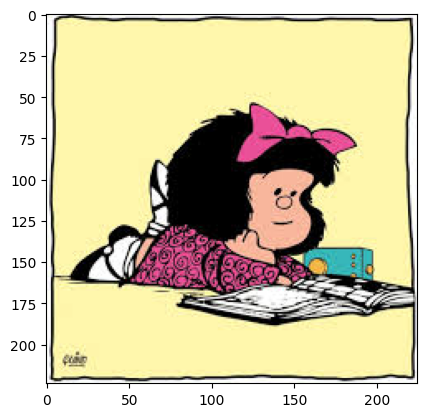

In [3]:
im = imread('mafalda.png')
show_image(im, ax='on')


#**CRECIMIENTO POR REGIONES**

In [4]:
dx = [-1, -1, -1, 0, 0, 1, 1, 1]
dy = [-1, 0, 1, -1, 1, -1, 0, 1]

In [5]:
im.shape

(224, 225, 3)

In [6]:
def obtener_rango(canal, umbral, im, x, y):
    im = im[:,:,canal]
    low = im[x][y] - umbral
    low = 0 if low < 0 else low
    high = im[x][y] + umbral
    high = 255 if high > 255 else high
    return low, high

In [7]:
def valido(low, high, x, y, im):
    r, c = im.shape
    if im[x][y] < low or im[x][y] > high:
        return False
    return True


In [8]:
def crecimiento_por_regiones(x, y, im, umbral):
    rango_canales = []
    for i in range(3):
        low, high = obtener_rango(i, umbral, im, x, y)
        rango_canales.append((low, high))

    vis = [[False for _ in range(im.shape[1])] for _ in range(im.shape[0])]
    dq = deque()
    dq.append((x, y))
    while dq:
        u, v = dq.popleft()
        vis[u][v] = True
        for i in range(8):
            newX = u + dx[i]
            newY = v + dy[i]
            if newX < 0 or newX >= im.shape[0] or newY < 0 or newY >= im.shape[1]:
                continue
            if vis[newX][newY]:
                continue

            ok = True
            for i in range(3):
                rango = rango_canales[i]
                if not valido(rango[0], rango[1], newX, newY, im[:,:,i]):
                    ok = False
                    break
            if ok:
                dq.append((newX, newY))
                vis[newX][newY] = True


    out = np.zeros_like(im)
    for i in range(3):
        for x in range(im.shape[0]):
            for y in range(im.shape[1]):
                if vis[x][y]:
                    out[x][y][i] = im[x][y][i]
    return out






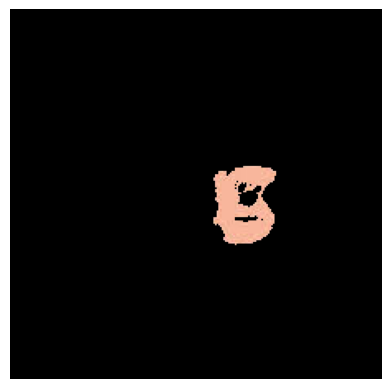

In [9]:
result = crecimiento_por_regiones(100, 150, im, 25)
show_image(result)

#**DIVISIÓN POR REGIONES**

In [40]:
def division_por_regiones(im, umbral):
    r, c, _ = im.shape

    promedio = np.mean(im)

    out = np.zeros_like(im)

    if r == 1 and c == 1:
        return out

    if r == 1:
        mid = c // 2
        region1 = im[:, :mid]
        region2 = im[:, mid:]

        #PRIMERA REGION
        if abs(np.mean(region1)-promedio) <= umbral:
            out[:, :mid] = region1
        else:
            out[:, :mid] = division_por_regiones(region1, umbral)

        #SEGUNDA REGION
        if abs(np.mean(region2)-promedio) <= umbral:
            out[:, mid:] = region2
        else:
            out[:, mid:] = division_por_regiones(region2, umbral)

        return out

    if c == 1:
        mid = r // 2
        region1 = im[:mid, :]
        region2 = im[mid:, :]

        #PRIMERA REGION
        if abs(np.mean(region1)-promedio) <= umbral:
            out[:mid, :] = region1
        else:
            out[:mid, :] = division_por_regiones(region1, umbral)

        #SEGUNDA REGION
        if abs(np.mean(region2)-promedio) <= umbral:
            out[mid:, :] = region2
        else:
            out[mid:, :] = division_por_regiones(region2, umbral)

        return out

    #punto medio
    punto_medio_x = c // 2
    punto_medio_y = r // 2

    #Dividir la imagen en regiones
    region1 = im[:punto_medio_x, :punto_medio_y]
    region2 = im[:punto_medio_x, punto_medio_y:]
    region3 = im[punto_medio_x:, :punto_medio_y]
    region4 = im[punto_medio_x:, punto_medio_y:]

    #PRIMERA REGION
    if abs(np.mean(region1)-promedio) <= umbral:
        out[:punto_medio_x, :punto_medio_y] = region1
    else:
        out[:punto_medio_x, :punto_medio_y] = division_por_regiones(region1, umbral)

    #SEGUNDA REGION
    if abs(np.mean(region2)-promedio) <= umbral:
        out[:punto_medio_x, punto_medio_y:] = region2
    else:
        out[:punto_medio_x, punto_medio_y:] = division_por_regiones(region2, umbral)

    #TERCERA REGION
    if abs(np.mean(region3)-promedio) <= umbral:
        out[punto_medio_x:, :punto_medio_y] = region3
    else:
        out[punto_medio_x:, :punto_medio_y] = division_por_regiones(region3, umbral)

    #CUARTA REGION
    if abs(np.mean(region4)-promedio) <= umbral:
        out[punto_medio_x:, punto_medio_y:] = region4
    else:
        out[punto_medio_x:, punto_medio_y:] = division_por_regiones(region4, umbral)

    return out

In [57]:
ejemplo = data.astronaut()

In [58]:
imagen = division_por_regiones(ejemplo, 0.6)

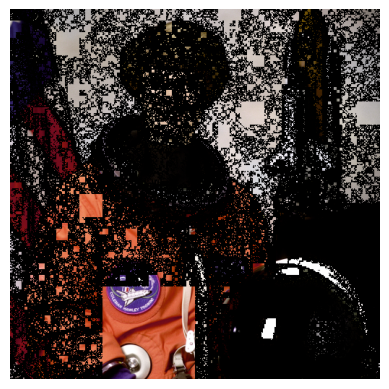

In [59]:
plt.imshow(imagen)
plt.axis('off')
plt.show()